##### Import libraries, defining directories, convert XPT to Parquet for more efficient data handling

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import pyreadstat
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

In [3]:
xpt_file_path = '/Users/arend/Desktop/CHD Prediction/LLCP2022.XPT' # Downloaded from https://www.cdc.gov/brfss/annual_data/annual_2022.html
parquet_file_path = '/Users/arend/Desktop/CHD Prediction/Parquet.parquet'

DataFrameMoreTrueDistribution_CSV = Path('/Users/arend/Desktop/CHD Prediction/DataFrameMoreTrueDistribution.csv')
DataFramePossiblyBiased_CSV = Path('/Users/arend/Desktop/CHD Prediction/DataFramePossiblyBiased.csv')

In [4]:
def convert_xpt_to_parquet(xpt_file_path, parquet_file_path):
    df, meta = pyreadstat.read_xport(xpt_file_path, encoding='ISO-8859-1')
    table = pa.Table.from_pandas(df)
    pq.write_table(table, parquet_file_path)

convert_xpt_to_parquet(xpt_file_path, parquet_file_path)

#### DataFrames (15 selected features, 111605 vs 61605 selected datapoints, categorical and numerical values, removed NaNs )

##### Reading dataset to get overview

In [5]:
DataFrame = pd.read_parquet(parquet_file_path)

In [6]:
DataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Columns: 328 entries, _STATE to _AIDTST4
dtypes: float64(323), object(5)
memory usage: 1.1+ GB


In [7]:
DataFrame.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_SMOKGRP,_LCSREC,DRNKANY6,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_FLSHOT7,_PNEUMO3,_AIDTST4
0,1.0,1.0,02032022,02,03,2022,1100.0,2022000001,2.022000e+09,1.0,...,4.0,NaN,2.0,0.0,1.0,0.0,1.0,1.0,2.0,2.0
1,1.0,1.0,02042022,02,04,2022,1100.0,2022000002,2.022000e+09,1.0,...,4.0,NaN,2.0,0.0,1.0,0.0,1.0,2.0,2.0,2.0
2,1.0,1.0,02022022,02,02,2022,1100.0,2022000003,2.022000e+09,1.0,...,4.0,NaN,2.0,0.0,1.0,0.0,1.0,NaN,NaN,2.0
3,1.0,1.0,02032022,02,03,2022,1100.0,2022000004,2.022000e+09,1.0,...,3.0,2.0,2.0,0.0,1.0,0.0,1.0,9.0,9.0,2.0
4,1.0,1.0,02022022,02,02,2022,1100.0,2022000005,2.022000e+09,1.0,...,4.0,NaN,1.0,10.0,1.0,140.0,1.0,NaN,NaN,2.0


##### Renaming selected features, removing all other columns, encoding feature values, removing rows with NaNs

In [8]:
replacement_mapping = {
    'MENTHLTH': 'BadMentalHealth30Days', 
    'EXERANY2': 'PhysicalActivity', 
    'SLEPTIM1': 'SleepTime', 
    'ADDEPEV3': 'HadDepressiveDisorder', 
    'DECIDE': 'BadMentalState',
    '_SMOKER3': 'Smoker', 
    'LCSFIRST':'StartedSmoke', 
    '_RACEGR4': 'Ethnicity', 
    '_AGEG5YR': 'Age', 
    '_BMI5': 'BMI', 
    'DRNKANY6': 'DrinkingAlcohol30Days', 
    'INCOME3':'Income', 
    '_URBSTAT':'UrbanOrRural',  
    '_SEX':'Sex',
    'CVDCRHD4': 'CHD'
}

DataFrame.rename(columns=replacement_mapping, inplace=True)

columns_to_keep = list(replacement_mapping.values())  # List of columns to keep
DataFrame = DataFrame[columns_to_keep]  # Keep only these columns

In [9]:
SEX = {1: 'Male', 2: 'Female'}

MENTAL_HEALTH = {
    77: np.nan,
    88: 0,
    99: np.nan
}

AGE_GROUPS = {
    1: "Age 18 to 24",
    2: "Age 25 to 29",
    3: "Age 30 to 34",
    4: "Age 35 to 39",
    5: "Age 40 to 44",
    6: "Age 45 to 49",
    7: "Age 50 to 54",
    8: "Age 55 to 59",
    9: "Age 60 to 64",
    10: "Age 65 to 69",
    11: "Age 70 to 74",
    12: "Age 75 to 79",
    13: "Age 80 or older",
    14: np.nan
}

INCOME_RANGE = {
    1: "Less than $10,000",
    2: "$10,000 to < $15,000",
    3: "$15,000 to < $20,000",
    4: "$20,000 to < $25,000",
    5: "$25,000 to < $35,000",
    6: "$35,000 to < $50,000",
    7: "$50,000 to < $75,000",
    8: "$75,000 to < $100,000",
    9: "$100,000 to < $150,000",
    10: "$150,000 to < $200,000",
    11: "$200,000 or more",
    77:  np.nan,
    99:  np.nan
}

HAD_DEPRESSIVE_DISORDER = {
    1: "Yes",
    2: "No",
    7:  np.nan,
    9:  np.nan
}

URBAN_OR_RURAL= {
    1: "Urban counties",
    2: "Rural counties",
}

SLEEP_TIME = lambda x: np.where(x > 24, np.nan, x)

SMOKER_STATUS = { 
    1: "Current smoker - now smokes every day",
    2: "Current smoker - now smokes some days",
    3: "Former smoker",
    4: "Never smoked",
    9:  np.nan
}

STARTED_SMOKING = lambda x: np.where(x > 100, np.nan, x)

ETHNICITY = {
    1: "White only, Non-Hispanic",
    2: "Black only, Non-Hispanic",
    3: "Other race only, Non-Hispanic",
    4: "Multiracial, Non-Hispanic",
    5: "Hispanic",
    9:  np.nan
}

MENTAL_STATE = {
    1: "Yes",
    2: "No",
    7:  np.nan,
    9:  np.nan
}

PHYSICAL_ACTIVITY = {
    1: "Yes",
    2: "No",
    7:  np.nan,
    9:  np.nan
}

DRINKING_ALCOHOL_30_DAYS = {
    1: "Yes",
    2: "No",
    7:  np.nan,
    9:  np.nan
}

CHD = {
    1: "Yes",
    2: "No",
    7:  np.nan,
    9:  np.nan
}

In [10]:
DataFrame['Sex'] = DataFrame['Sex'].map(SEX)
DataFrame['BadMentalHealth30Days'] = DataFrame['BadMentalHealth30Days'].replace(MENTAL_HEALTH)
DataFrame['HadDepressiveDisorder'] = DataFrame['HadDepressiveDisorder'].map(HAD_DEPRESSIVE_DISORDER)
DataFrame['Age'] = DataFrame['Age'].map(AGE_GROUPS)
DataFrame['UrbanOrRural'] = DataFrame['UrbanOrRural'].map(URBAN_OR_RURAL)
DataFrame['Income'] = DataFrame['Income'].map(INCOME_RANGE)
DataFrame['BMI'] = DataFrame['BMI'] / 100
DataFrame['BadMentalState'] = DataFrame['BadMentalState'].map(MENTAL_STATE)
DataFrame['StartedSmoke'] = DataFrame['StartedSmoke'].map(STARTED_SMOKING)
DataFrame['Smoker'] = DataFrame['Smoker'].map(SMOKER_STATUS)
DataFrame['DrinkingAlcohol30Days'] = DataFrame['DrinkingAlcohol30Days'].map(DRINKING_ALCOHOL_30_DAYS)
DataFrame['SleepTime'] = DataFrame['SleepTime'].map(SLEEP_TIME)
DataFrame['PhysicalActivity'] = DataFrame['PhysicalActivity'].map(PHYSICAL_ACTIVITY)
DataFrame['Ethnicity'] = DataFrame['Ethnicity'].map(ETHNICITY)
DataFrame['CHD'] = DataFrame['CHD'].map(CHD)

In [11]:
DataFrame = DataFrame.copy()
DataFrame = DataFrame.dropna(axis=0) # Remove rows containing NaNs (Looks like the NaNs are relatively random distributed relative to the affect on target feature)

DataFrameMoreTrueDistribution = DataFrame.copy()

#REMOVE? These three lines are for handling the imbalance on the target value 'CHD' (tried other more convenient methods, but without improving results)
DataFramePossiblyBiased = DataFrame.copy()
rows_to_remove = 50000 #92247 
indices_to_remove = DataFramePossiblyBiased.index[DataFrame['CHD'] == 'No'][:rows_to_remove]
DataFramePossiblyBiased = DataFramePossiblyBiased.drop(indices_to_remove)  
#Will test if the model gets biased so i save it to a different dataset. The PossibleBiased to train on and the true distribution to evaluate the performance.

In [12]:
print("Number of rows:", DataFrameMoreTrueDistribution.shape[0])
print("Number of columns:", DataFrameMoreTrueDistribution.shape[1])

for column in DataFrameMoreTrueDistribution.columns: # Check percentage of missing data in each column (should be 0)
    missing_percentage = (DataFrameMoreTrueDistribution[column].isnull().sum() / len(DataFrameMoreTrueDistribution)) * 100
    print(f"{column}: {missing_percentage:.2f}% missing")

Number of rows: 111605
Number of columns: 15
BadMentalHealth30Days: 0.00% missing
PhysicalActivity: 0.00% missing
SleepTime: 0.00% missing
HadDepressiveDisorder: 0.00% missing
BadMentalState: 0.00% missing
Smoker: 0.00% missing
StartedSmoke: 0.00% missing
Ethnicity: 0.00% missing
Age: 0.00% missing
BMI: 0.00% missing
DrinkingAlcohol30Days: 0.00% missing
Income: 0.00% missing
UrbanOrRural: 0.00% missing
Sex: 0.00% missing
CHD: 0.00% missing


In [13]:
print("Number of rows:", DataFramePossiblyBiased.shape[0])
print("Number of columns:", DataFramePossiblyBiased.shape[1])

for column in DataFramePossiblyBiased.columns: # Check percentage of missing data in each column (should be 0)
    missing_percentage = (DataFramePossiblyBiased[column].isnull().sum() / len(DataFramePossiblyBiased)) * 100
    print(f"{column}: {missing_percentage:.2f}% missing")

Number of rows: 61605
Number of columns: 15
BadMentalHealth30Days: 0.00% missing
PhysicalActivity: 0.00% missing
SleepTime: 0.00% missing
HadDepressiveDisorder: 0.00% missing
BadMentalState: 0.00% missing
Smoker: 0.00% missing
StartedSmoke: 0.00% missing
Ethnicity: 0.00% missing
Age: 0.00% missing
BMI: 0.00% missing
DrinkingAlcohol30Days: 0.00% missing
Income: 0.00% missing
UrbanOrRural: 0.00% missing
Sex: 0.00% missing
CHD: 0.00% missing


##### Checking unique values, data distribution and get overview again

In [14]:
def describe_df(df: pd.DataFrame):
    print(f"The dataset contains {df.shape[1]} columns and {len(df)} rows")

    for col in df.columns:
        col_dtype = df[col].dtype
        
        print(f"\nColumn: {col} ({col_dtype})")
        if col_dtype == 'object':
            print(f"--- Unique values:\n {df[col].unique()}")
        else:
            print(f"--- Summary statistics:\n {df[col].describe()}")

In [15]:
describe_df(DataFrameMoreTrueDistribution)

The dataset contains 15 columns and 111605 rows

Column: BadMentalHealth30Days (float64)
--- Summary statistics:
 count    111605.00000
mean          5.31969
std           9.27672
min           0.00000
25%           0.00000
50%           0.00000
75%           5.00000
max          30.00000
Name: BadMentalHealth30Days, dtype: float64

Column: PhysicalActivity (object)
--- Unique values:
 ['Yes' 'No']

Column: SleepTime (float64)
--- Summary statistics:
 count    111605.000000
mean          6.973684
std           1.574351
min           1.000000
25%           6.000000
50%           7.000000
75%           8.000000
max          24.000000
Name: SleepTime, dtype: float64

Column: HadDepressiveDisorder (object)
--- Unique values:
 ['No' 'Yes']

Column: BadMentalState (object)
--- Unique values:
 ['No' 'Yes']

Column: Smoker (object)
--- Unique values:
 ['Former smoker' 'Current smoker - now smokes some days'
 'Current smoker - now smokes every day']

Column: StartedSmoke (float64)
--- Summary s

In [16]:
describe_df(DataFramePossiblyBiased)

The dataset contains 15 columns and 61605 rows

Column: BadMentalHealth30Days (float64)
--- Summary statistics:
 count    61605.000000
mean         5.369694
std          9.324573
min          0.000000
25%          0.000000
50%          0.000000
75%          5.000000
max         30.000000
Name: BadMentalHealth30Days, dtype: float64

Column: PhysicalActivity (object)
--- Unique values:
 ['Yes' 'No']

Column: SleepTime (float64)
--- Summary statistics:
 count    61605.000000
mean         6.988134
std          1.585999
min          1.000000
25%          6.000000
50%          7.000000
75%          8.000000
max         24.000000
Name: SleepTime, dtype: float64

Column: HadDepressiveDisorder (object)
--- Unique values:
 ['No' 'Yes']

Column: BadMentalState (object)
--- Unique values:
 ['No' 'Yes']

Column: Smoker (object)
--- Unique values:
 ['Current smoker - now smokes some days' 'Former smoker'
 'Current smoker - now smokes every day']

Column: StartedSmoke (float64)
--- Summary statistics


Class distribution for BadMentalHealth30Days:
BadMentalHealth30Days
0.0     64176
30.0     9272
2.0      5862
5.0      5047
15.0     4477
10.0     4270
3.0      3867
1.0      3283
20.0     2804
4.0      2046
7.0      2039
25.0      971
14.0      804
6.0       594
8.0       455
12.0      342
28.0      297
21.0      175
29.0      163
9.0        93
18.0       88
16.0       85
17.0       72
22.0       68
27.0       66
13.0       54
11.0       36
26.0       33
24.0       31
23.0       26
19.0        9
Name: count, dtype: int64


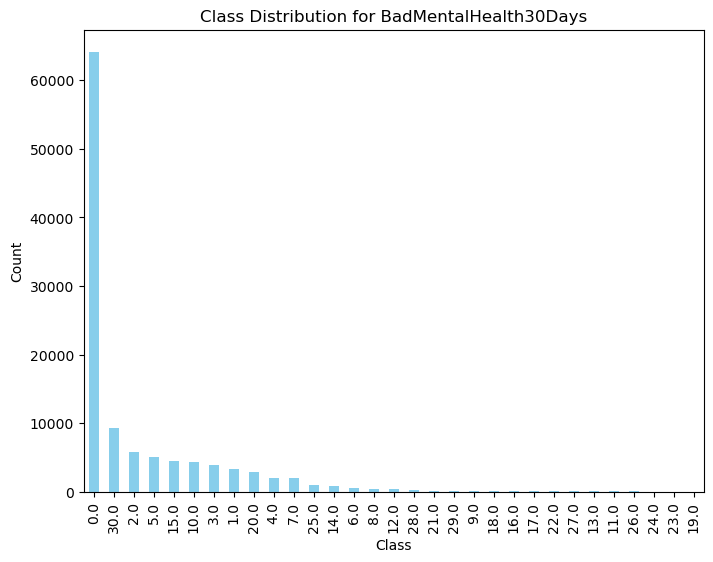


Class distribution for PhysicalActivity:
PhysicalActivity
Yes    81027
No     30578
Name: count, dtype: int64


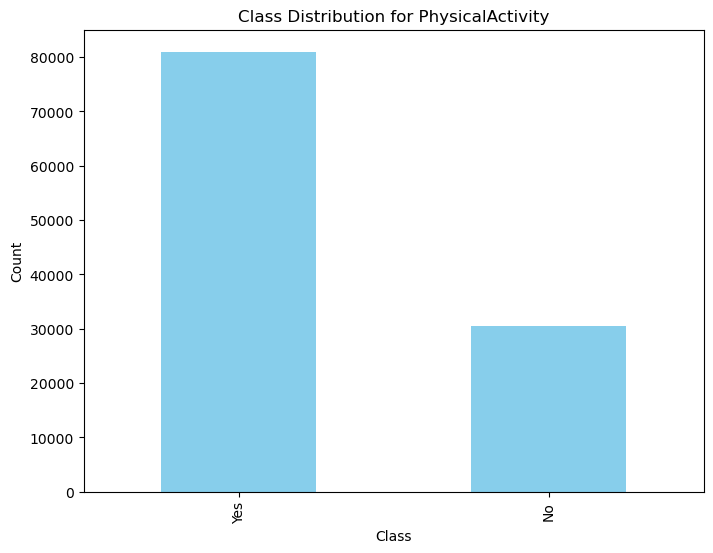


Class distribution for SleepTime:
SleepTime
7.0     30799
8.0     30105
6.0     25809
5.0      8901
9.0      5688
4.0      3991
10.0     3117
3.0      1031
12.0      901
2.0       403
1.0       221
11.0      183
14.0       97
15.0       96
16.0       93
13.0       53
18.0       53
20.0       38
17.0        7
23.0        6
24.0        6
22.0        4
19.0        3
Name: count, dtype: int64


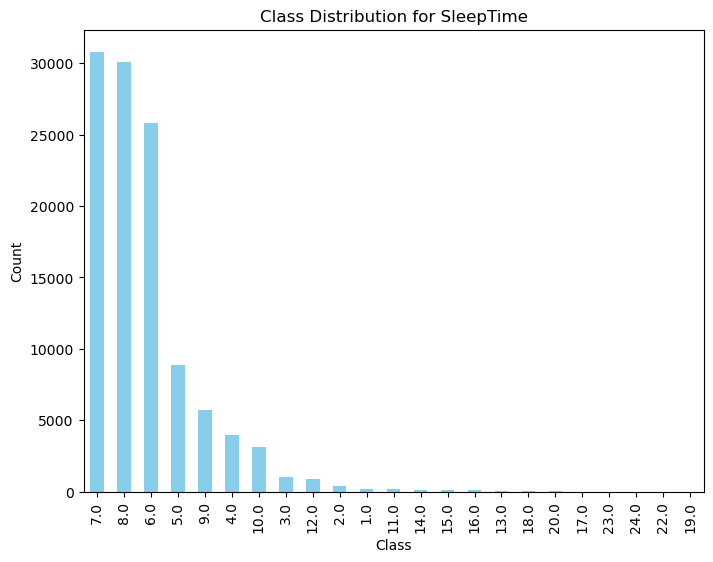


Class distribution for HadDepressiveDisorder:
HadDepressiveDisorder
No     81727
Yes    29878
Name: count, dtype: int64


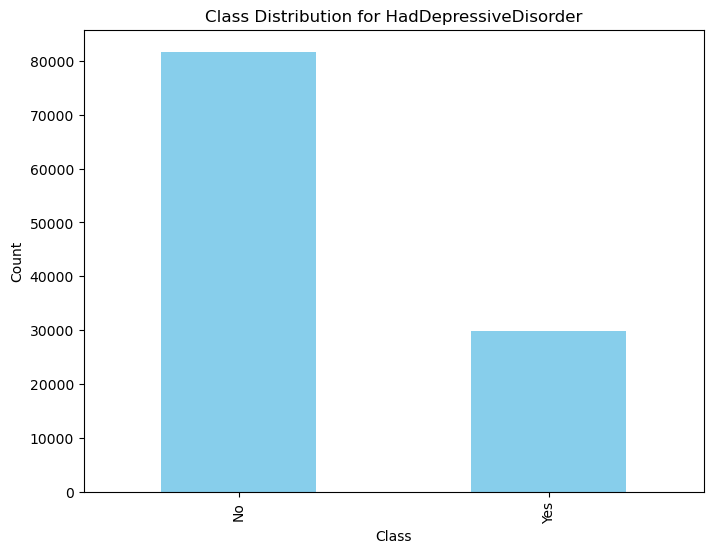


Class distribution for BadMentalState:
BadMentalState
No     94925
Yes    16680
Name: count, dtype: int64


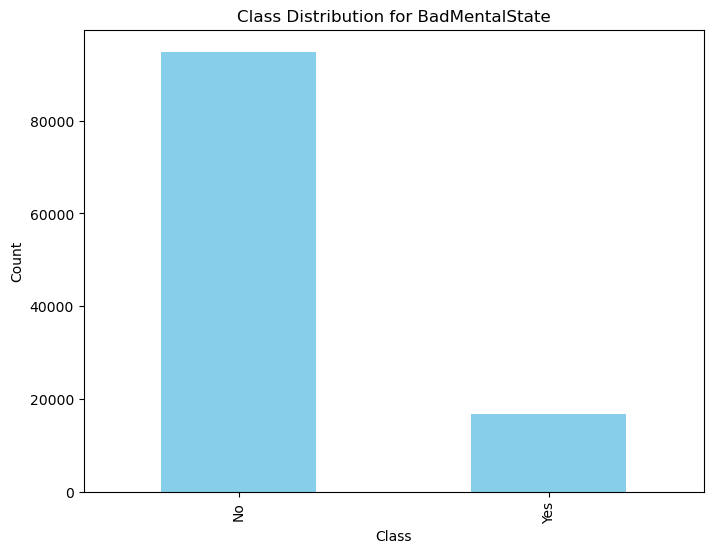


Class distribution for Smoker:
Smoker
Former smoker                            77132
Current smoker - now smokes every day    25282
Current smoker - now smokes some days     9191
Name: count, dtype: int64


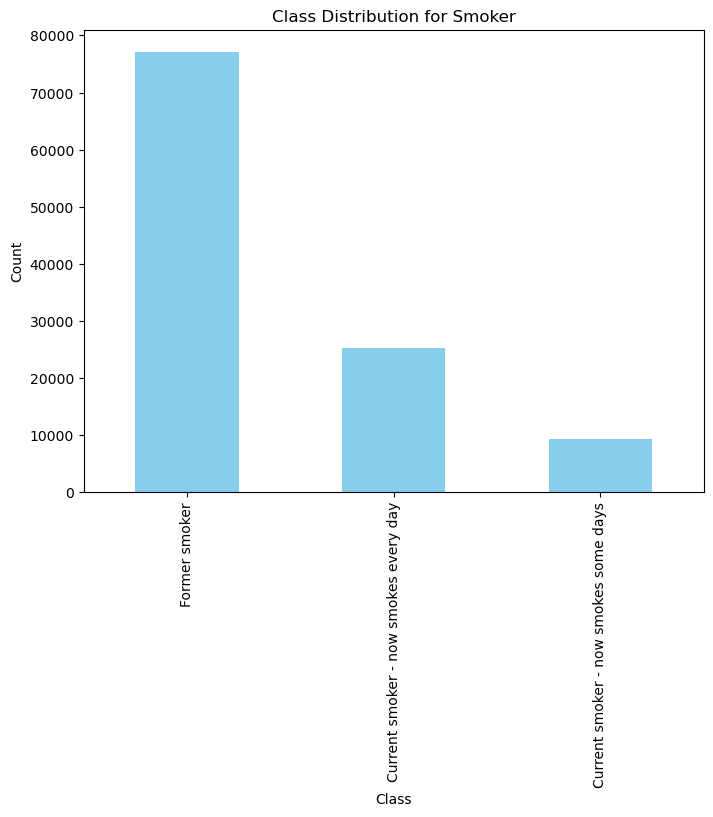


Class distribution for StartedSmoke:
StartedSmoke
18.0    20116
16.0    15968
15.0    11726
17.0     9804
20.0     9164
        ...  
80.0        1
78.0        1
67.0        1
99.0        1
74.0        1
Name: count, Length: 79, dtype: int64


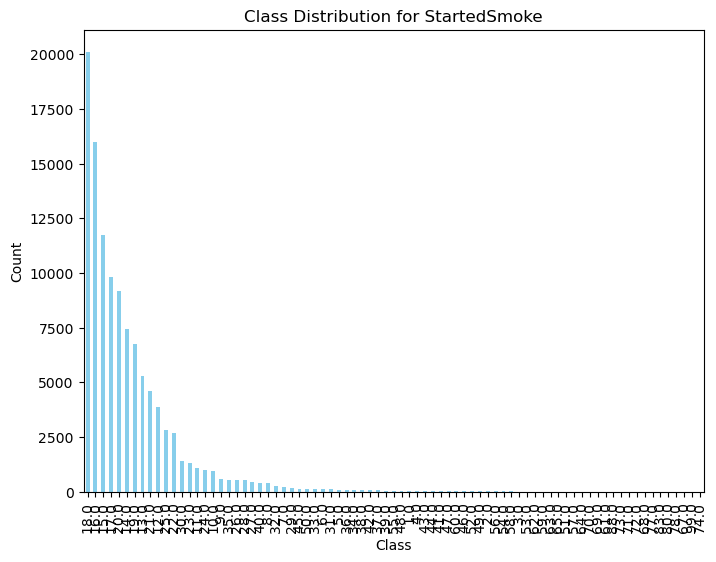


Class distribution for Ethnicity:
Ethnicity
White only, Non-Hispanic         90455
Black only, Non-Hispanic          6966
Hispanic                          6756
Other race only, Non-Hispanic     4559
Multiracial, Non-Hispanic         2869
Name: count, dtype: int64


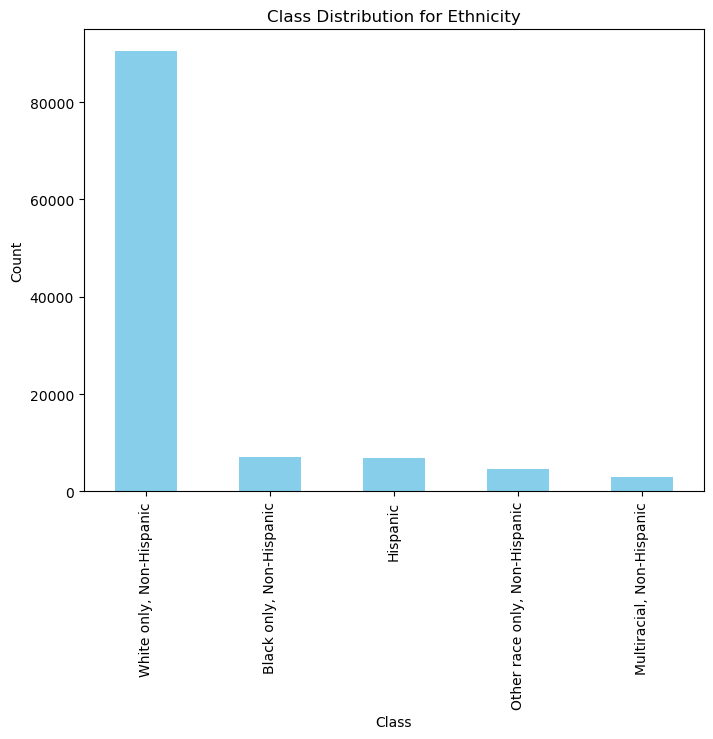


Class distribution for Age:
Age
Age 65 to 69       13713
Age 60 to 64       12811
Age 70 to 74       12559
Age 55 to 59        9972
Age 75 to 79        9667
Age 80 or older     8814
Age 40 to 44        8811
Age 50 to 54        8698
Age 45 to 49        7848
Age 35 to 39        7402
Age 30 to 34        5710
Age 25 to 29        3579
Age 18 to 24        2021
Name: count, dtype: int64


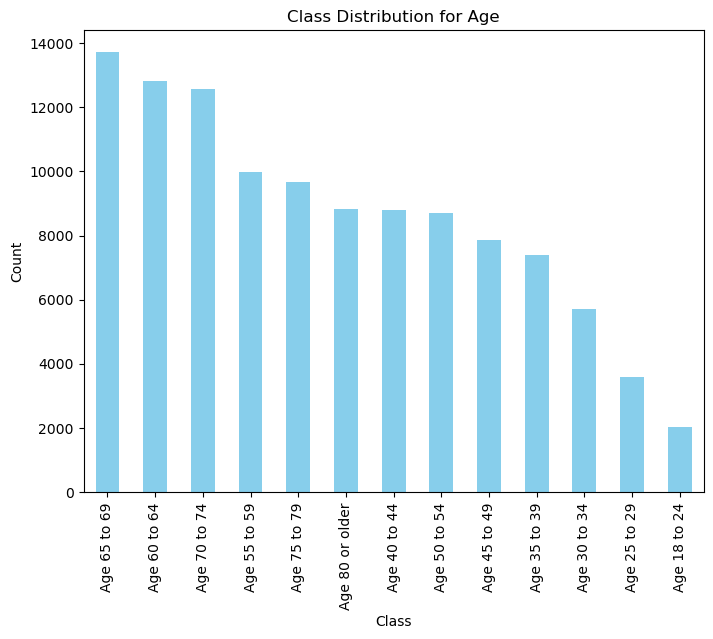


Class distribution for BMI:
BMI
26.63    1175
24.41     913
27.12     871
27.46     864
25.10     819
         ... 
32.80       1
21.45       1
12.50       1
41.34       1
25.93       1
Name: count, Length: 2949, dtype: int64


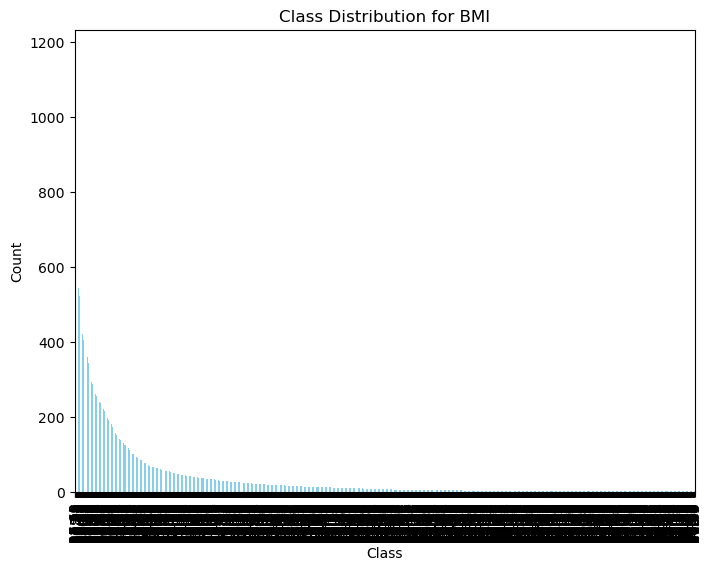


Class distribution for DrinkingAlcohol30Days:
DrinkingAlcohol30Days
Yes    63219
No     48386
Name: count, dtype: int64


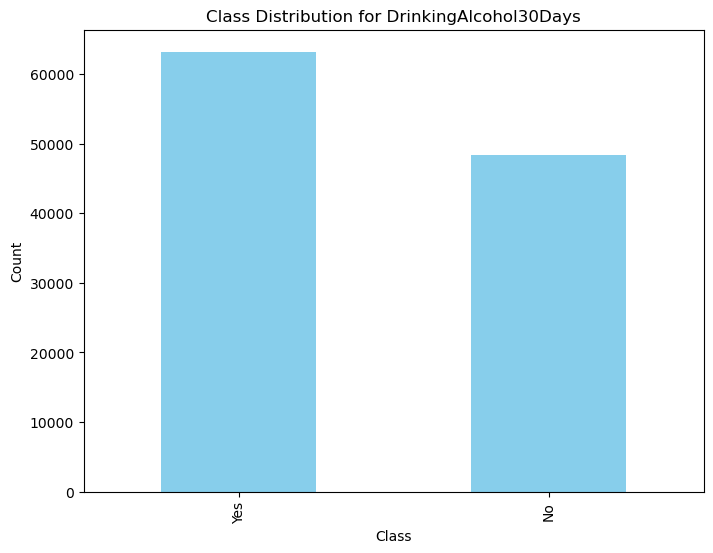


Class distribution for Income:
Income
$50,000 to < $75,000      19719
$35,000 to < $50,000      15998
$25,000 to < $35,000      15100
$75,000 to < $100,000     14911
$100,000 to < $150,000    14174
$20,000 to < $25,000       7502
$150,000 to < $200,000     5735
$15,000 to < $20,000       5415
$200,000 or more           5138
$10,000 to < $15,000       4379
Less than $10,000          3534
Name: count, dtype: int64


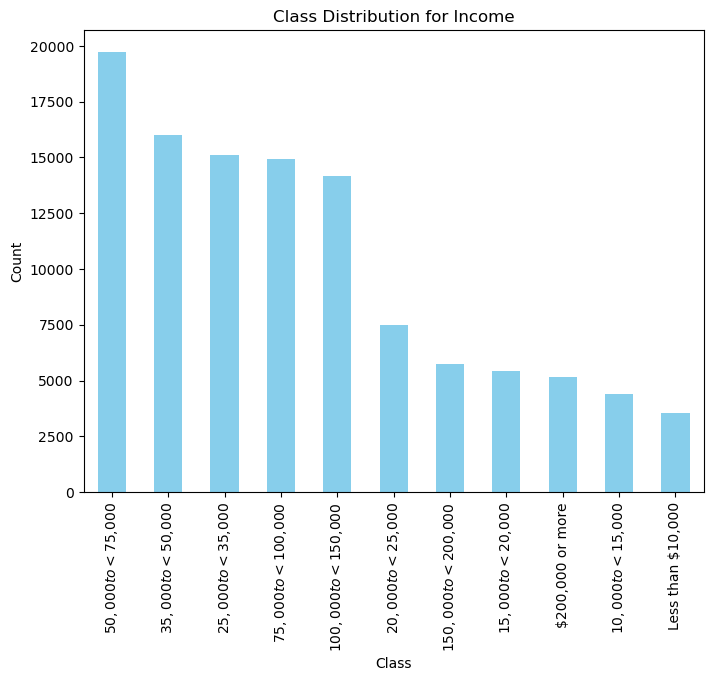


Class distribution for UrbanOrRural:
UrbanOrRural
Urban counties    95559
Rural counties    16046
Name: count, dtype: int64


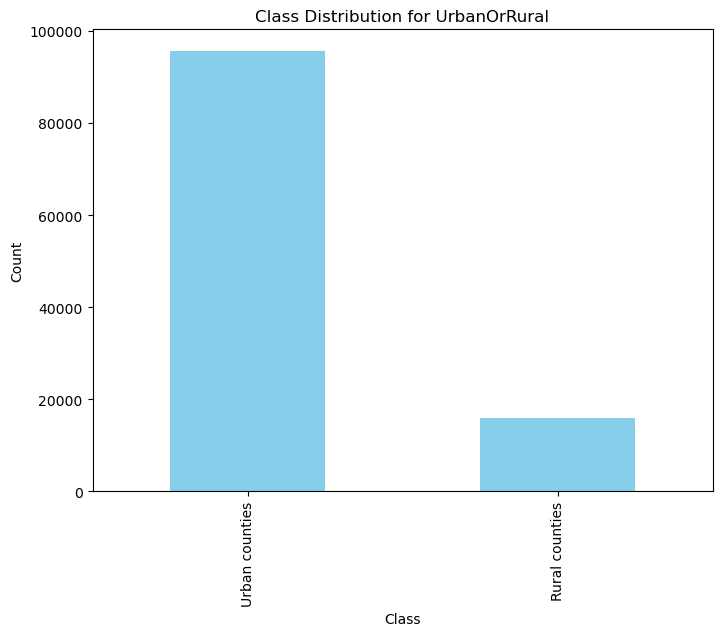


Class distribution for Sex:
Sex
Male      59418
Female    52187
Name: count, dtype: int64


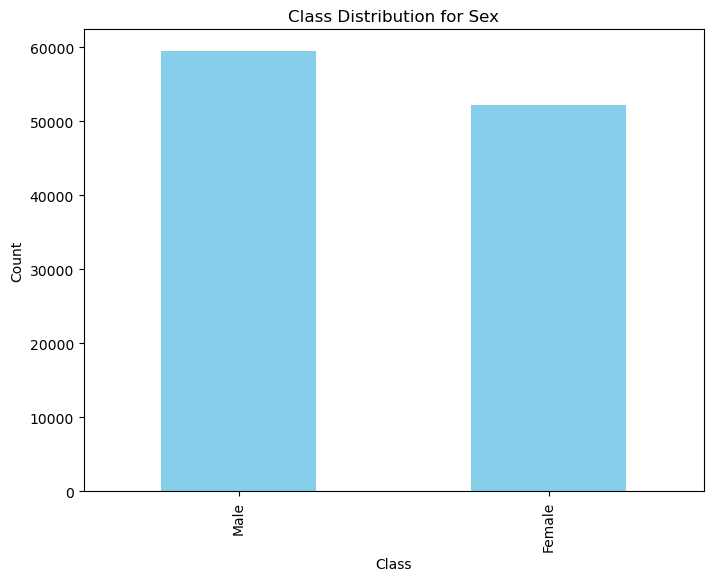


Class distribution for CHD:
CHD
No     101926
Yes      9679
Name: count, dtype: int64


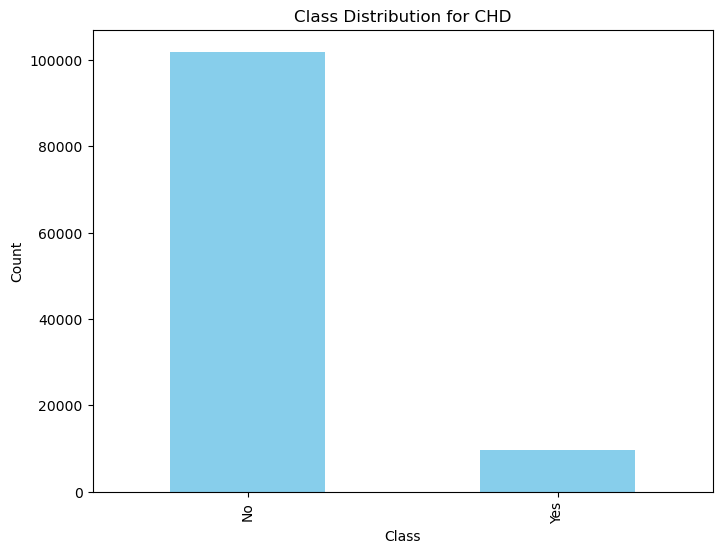

In [17]:
target_features = ['BadMentalHealth30Days', 'PhysicalActivity', 'SleepTime', 'HadDepressiveDisorder', 'BadMentalState', 'Smoker', 'StartedSmoke', 'Ethnicity', 'Age', 'BMI', 'DrinkingAlcohol30Days', 'Income', 'UrbanOrRural', 'Sex','CHD'] #Lets include all features

for feature in target_features:
    class_counts = DataFrameMoreTrueDistribution[feature].value_counts()
    
    print(f"\nClass distribution for {feature}:")
    print(class_counts)
    
    # Plot the class distribution
    plt.figure(figsize=(8, 6))
    class_counts.plot(kind='bar', color='skyblue')
    plt.title(f"Class Distribution for {feature}")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()


Class distribution for BadMentalHealth30Days:
BadMentalHealth30Days
0.0     35459
30.0     5188
2.0      3185
5.0      2778
15.0     2553
10.0     2357
3.0      2111
1.0      1751
20.0     1568
4.0      1107
7.0      1091
25.0      554
14.0      422
6.0       339
8.0       246
12.0      187
28.0      164
21.0      106
29.0       87
16.0       52
9.0        50
18.0       45
17.0       37
22.0       33
13.0       32
27.0       31
26.0       19
11.0       19
24.0       16
23.0       13
19.0        5
Name: count, dtype: int64


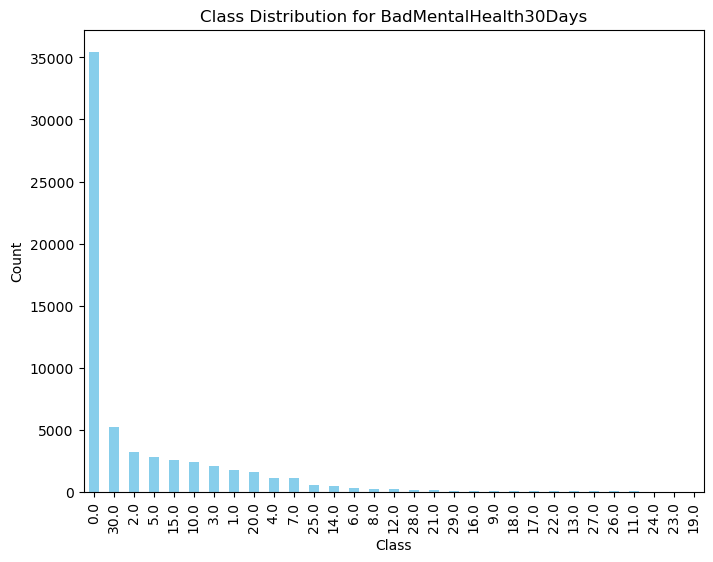


Class distribution for PhysicalActivity:
PhysicalActivity
Yes    44166
No     17439
Name: count, dtype: int64


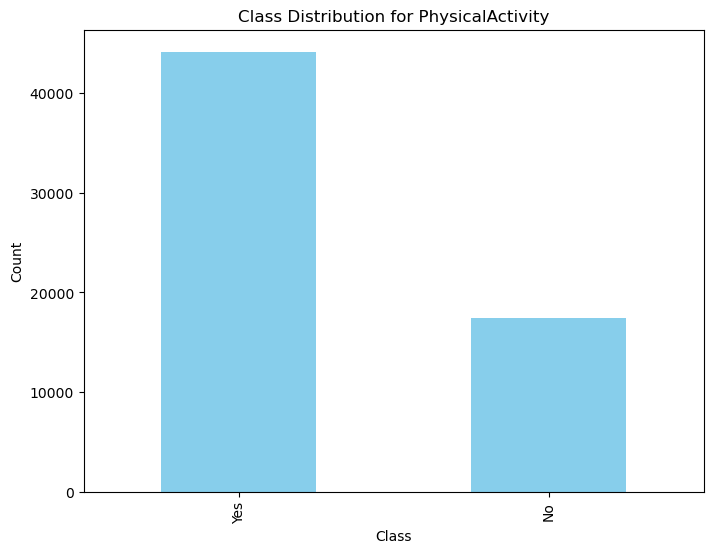


Class distribution for SleepTime:
SleepTime
7.0     16930
8.0     16759
6.0     14093
5.0      4870
9.0      3182
4.0      2215
10.0     1761
3.0       559
12.0      517
2.0       230
1.0       113
11.0      106
16.0       59
14.0       53
15.0       53
13.0       34
18.0       29
20.0       26
17.0        6
22.0        4
23.0        3
19.0        2
24.0        1
Name: count, dtype: int64


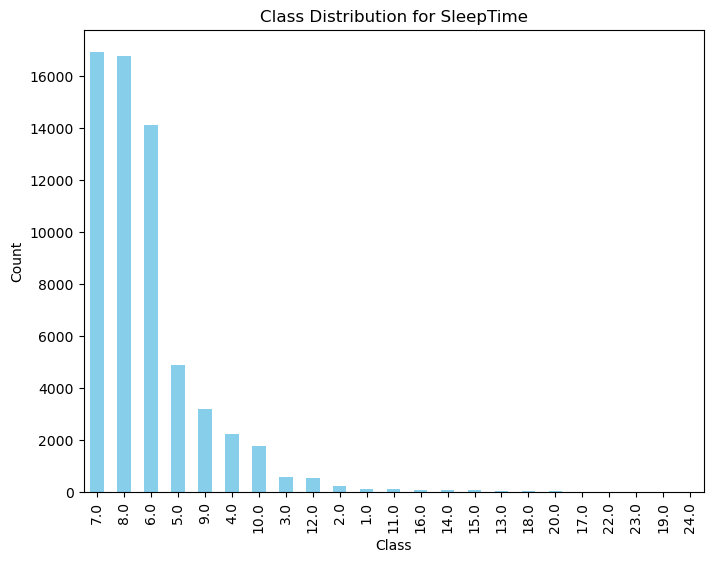


Class distribution for HadDepressiveDisorder:
HadDepressiveDisorder
No     44675
Yes    16930
Name: count, dtype: int64


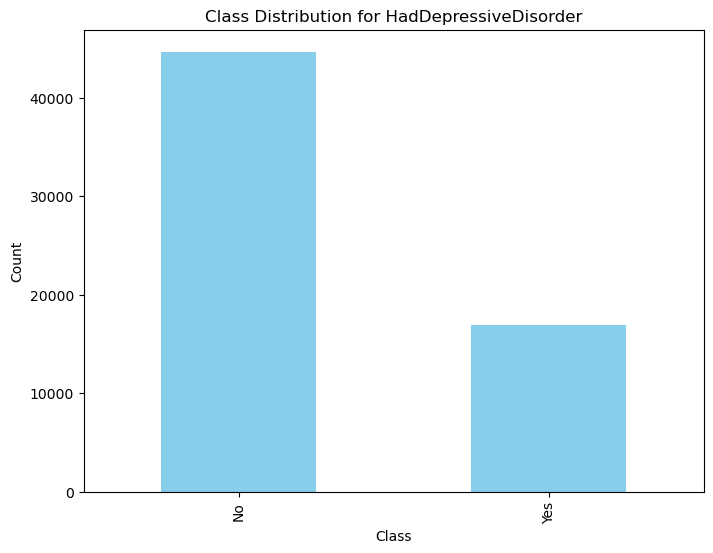


Class distribution for BadMentalState:
BadMentalState
No     52207
Yes     9398
Name: count, dtype: int64


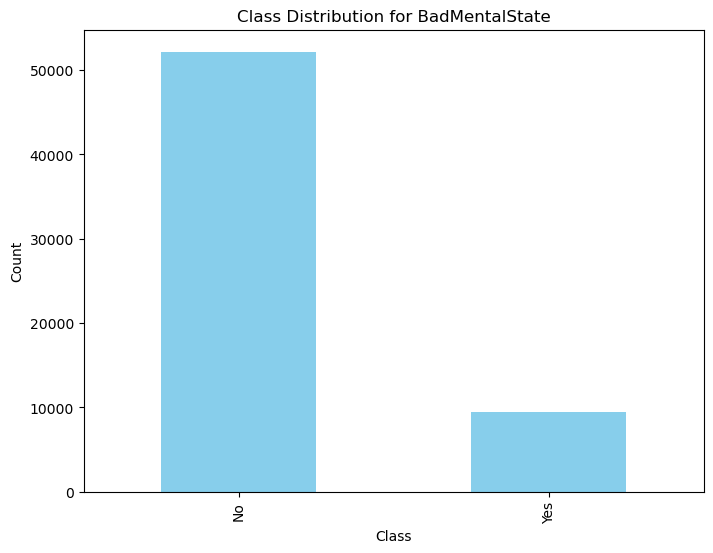


Class distribution for Smoker:
Smoker
Former smoker                            42801
Current smoker - now smokes every day    13856
Current smoker - now smokes some days     4948
Name: count, dtype: int64


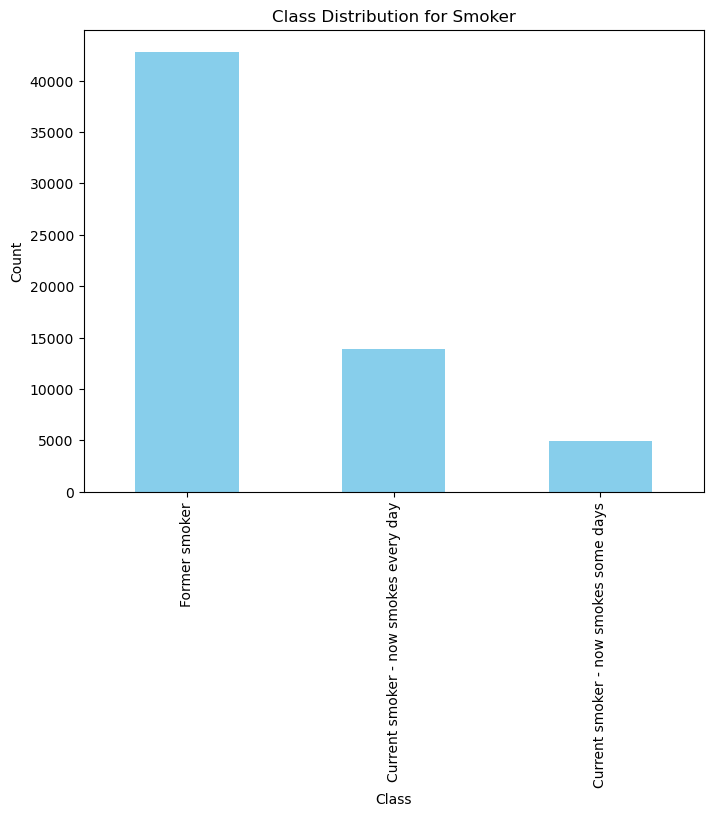


Class distribution for StartedSmoke:
StartedSmoke
18.0    11197
16.0     8776
15.0     6447
17.0     5385
20.0     5079
        ...  
77.0        1
88.0        1
70.0        1
61.0        1
72.0        1
Name: count, Length: 76, dtype: int64


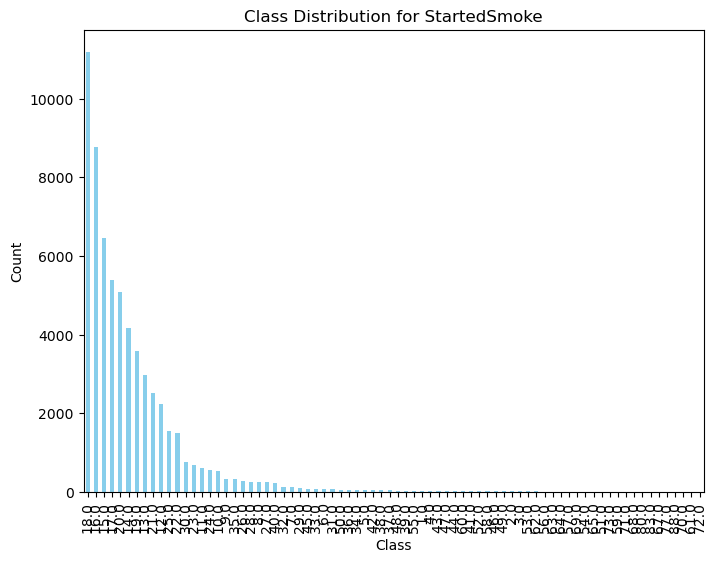


Class distribution for Ethnicity:
Ethnicity
White only, Non-Hispanic         51088
Hispanic                          3665
Black only, Non-Hispanic          3077
Other race only, Non-Hispanic     2371
Multiracial, Non-Hispanic         1404
Name: count, dtype: int64


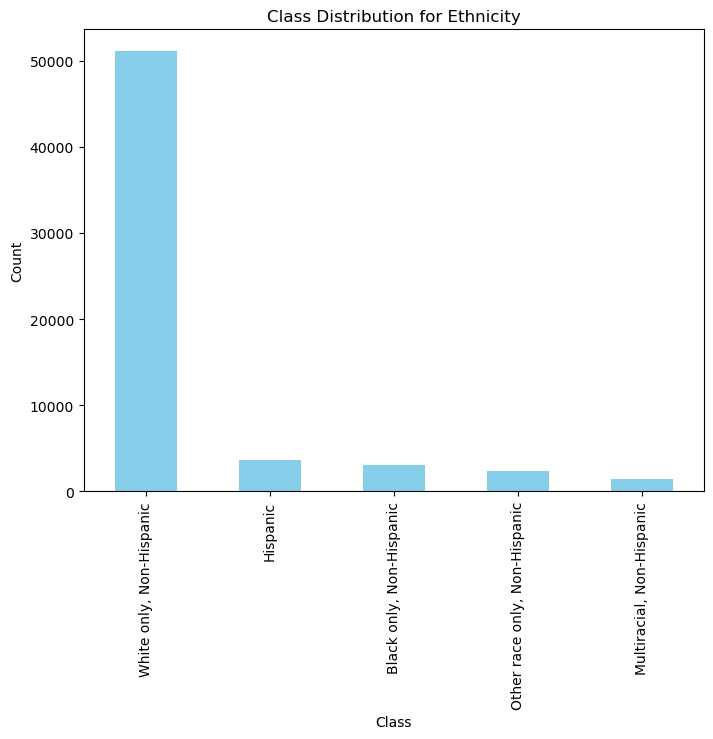


Class distribution for Age:
Age
Age 65 to 69       7819
Age 70 to 74       7220
Age 60 to 64       7153
Age 75 to 79       5759
Age 55 to 59       5394
Age 80 or older    5305
Age 50 to 54       4709
Age 40 to 44       4610
Age 45 to 49       4150
Age 35 to 39       3751
Age 30 to 34       2903
Age 25 to 29       1806
Age 18 to 24       1026
Name: count, dtype: int64


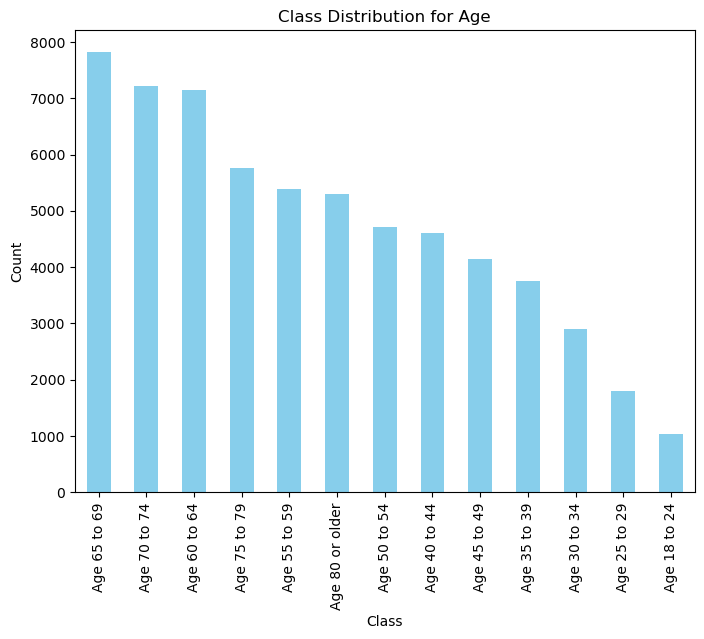


Class distribution for BMI:
BMI
26.63    634
24.41    499
25.10    480
27.12    479
27.46    473
        ... 
60.23      1
18.12      1
41.46      1
12.78      1
38.49      1
Name: count, Length: 2618, dtype: int64


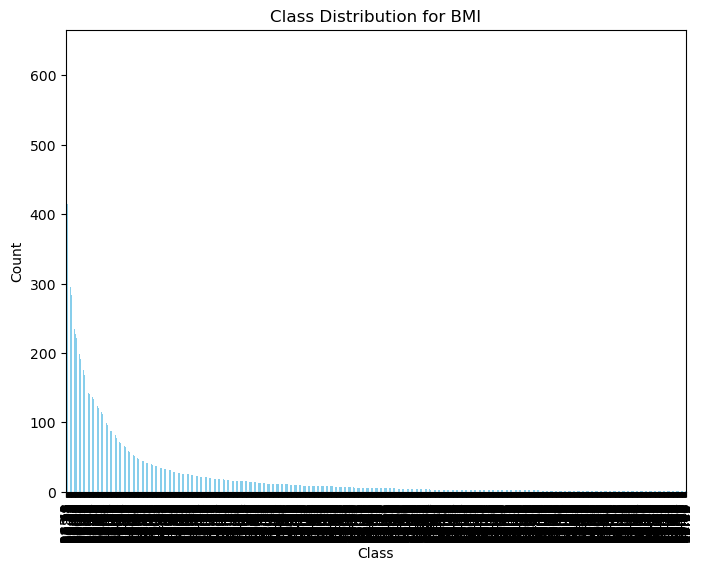


Class distribution for DrinkingAlcohol30Days:
DrinkingAlcohol30Days
Yes    34307
No     27298
Name: count, dtype: int64


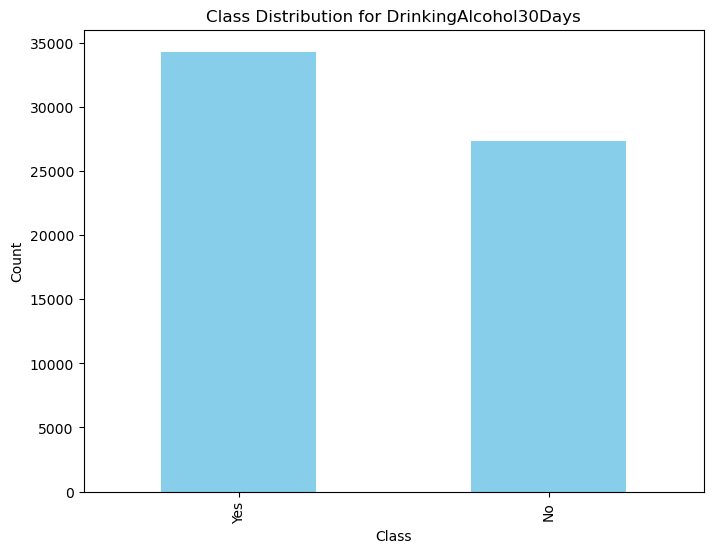


Class distribution for Income:
Income
$50,000 to < $75,000      10876
$35,000 to < $50,000       8932
$25,000 to < $35,000       8377
$75,000 to < $100,000      8260
$100,000 to < $150,000     7617
$20,000 to < $25,000       4212
$15,000 to < $20,000       3085
$150,000 to < $200,000     3062
$200,000 or more           2676
$10,000 to < $15,000       2544
Less than $10,000          1964
Name: count, dtype: int64


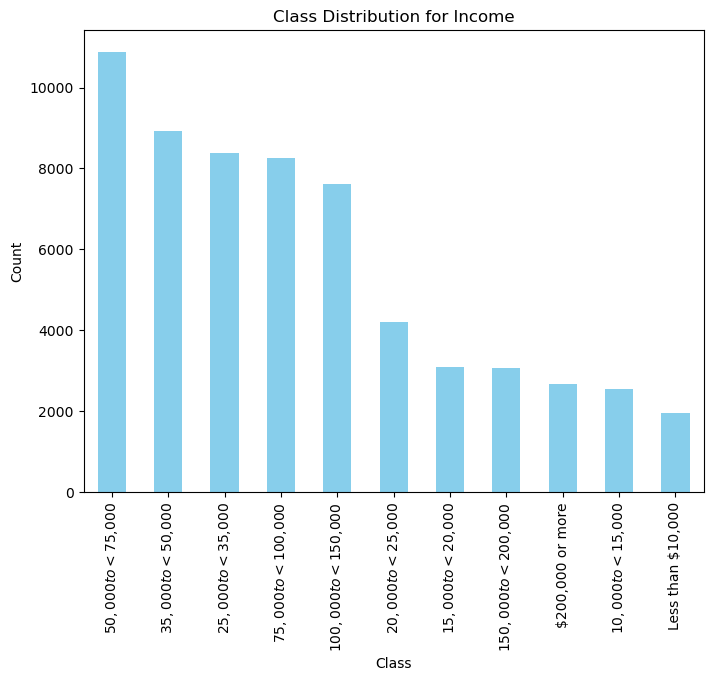


Class distribution for UrbanOrRural:
UrbanOrRural
Urban counties    52586
Rural counties     9019
Name: count, dtype: int64


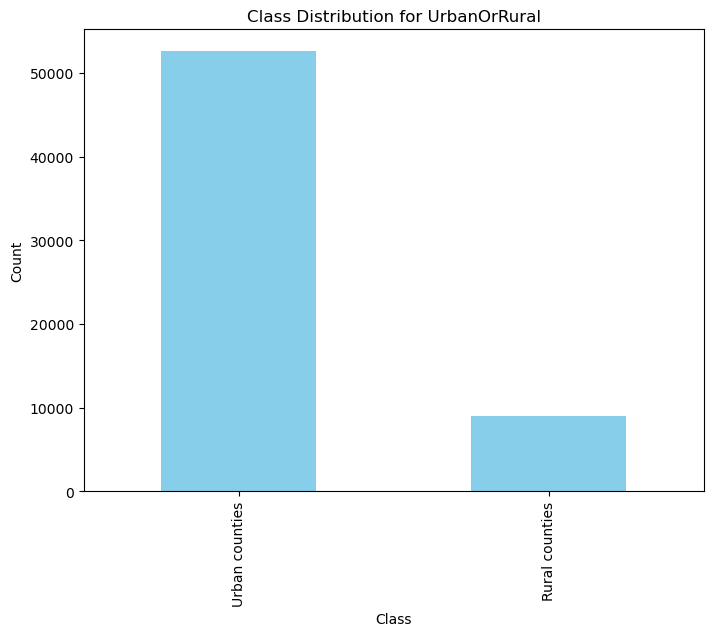


Class distribution for Sex:
Sex
Male      33306
Female    28299
Name: count, dtype: int64


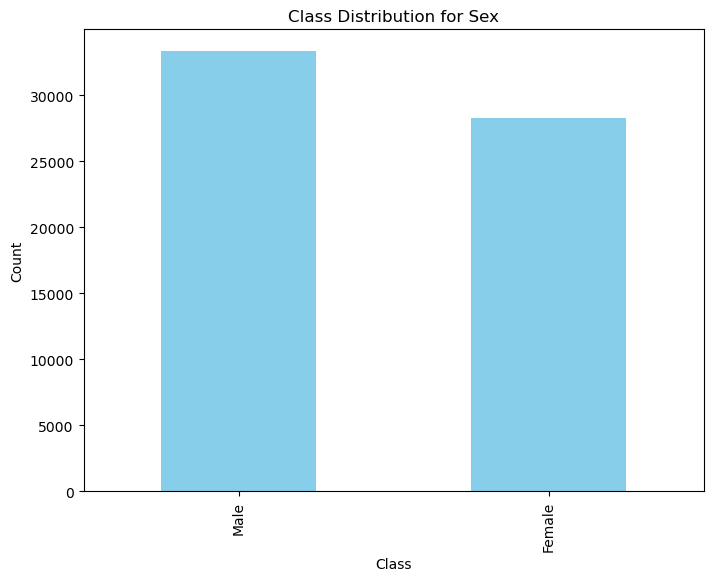


Class distribution for CHD:
CHD
No     51926
Yes     9679
Name: count, dtype: int64


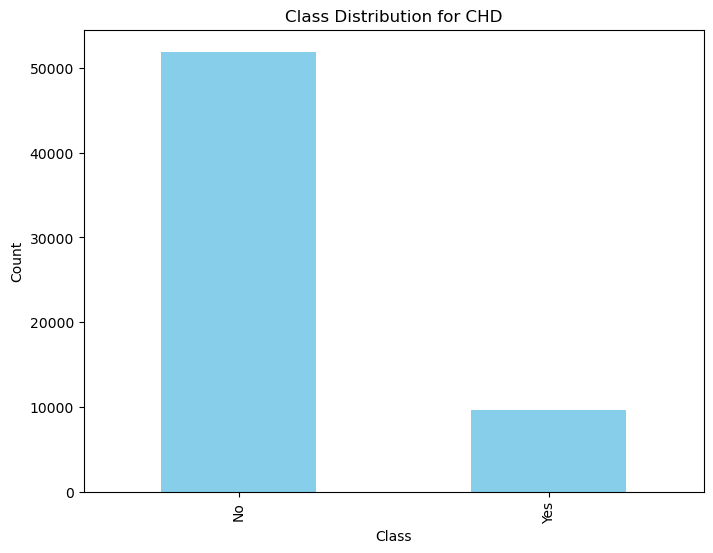

In [18]:
target_features = ['BadMentalHealth30Days', 'PhysicalActivity', 'SleepTime', 'HadDepressiveDisorder', 'BadMentalState', 'Smoker', 'StartedSmoke', 'Ethnicity', 'Age', 'BMI', 'DrinkingAlcohol30Days', 'Income', 'UrbanOrRural', 'Sex','CHD'] #Lets include all features

for feature in target_features:
    class_counts = DataFramePossiblyBiased[feature].value_counts()
    
    print(f"\nClass distribution for {feature}:")
    print(class_counts)
    
    # Plot the class distribution
    plt.figure(figsize=(8, 6))
    class_counts.plot(kind='bar', color='skyblue')
    plt.title(f"Class Distribution for {feature}")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

##### Convert parquet to csv

In [19]:
DataFrameMoreTrueDistribution.to_csv(DataFrameMoreTrueDistribution_CSV, index=False)
DataFramePossiblyBiased.to_csv(DataFramePossiblyBiased_CSV, index=False)

#### Additional Exploratory Analysis

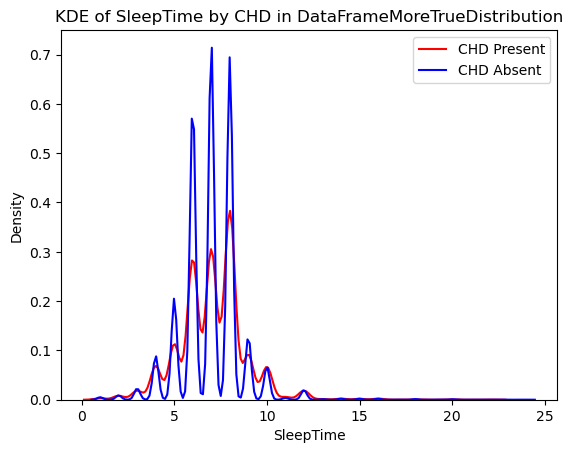

In [25]:
""" If the CHD present curve is shifted towards higher feature values compared to the 'CHD Absent' curve,
it may indicate that individuals with CHD tend to have higher values of the feature on average and vice versa. 

A close fit between the curves suggests that the feature may not be strongly associated with the presence or absence of CHD.
In other words, variations in this feature may not be indicative of a higher or lower risk of CHD.

The curves can vary in the y axis because of imbalanced features. (For instance, people who have CHD are overrepresented)
"""

import seaborn as sns
import matplotlib.pyplot as plt

df = DataFrameMoreTrueDistribution.copy()
feature = 'SleepTime'

# Encode 'CHD' to numeric values
df['CHD_numeric'] = df['CHD'].map({'Yes': 1, 'No': 0})

# Plot KDE for 'SleepTime' against 'CHD'
sns.kdeplot(data=df[df['CHD'] == 'Yes'][feature], label='CHD Present', color='red')
sns.kdeplot(data=df[df['CHD'] == 'No'][feature], label='CHD Absent', color='blue')
plt.xlabel(feature)
plt.ylabel('Density')
plt.title(f'KDE of {feature} by CHD in DataFrameMoreTrueDistribution')
plt.legend()
plt.show()

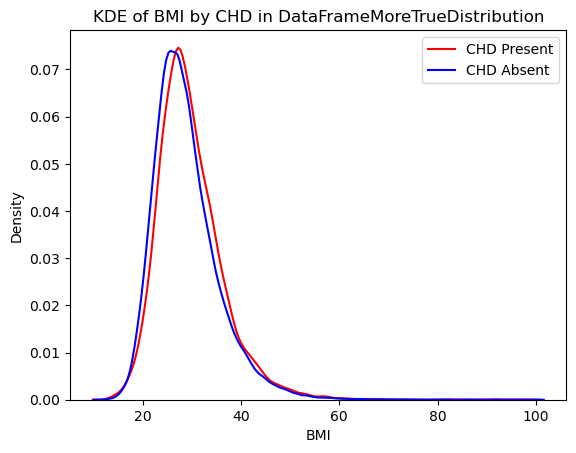

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

df = DataFrameMoreTrueDistribution.copy()
feature = 'BMI'

# Encode 'CHD' to numeric values
df['CHD_numeric'] = df['CHD'].map({'Yes': 1, 'No': 0})

# Plot KDE for 'SleepTime' against 'CHD'
sns.kdeplot(data=df[df['CHD'] == 'Yes'][feature], label='CHD Present', color='red')
sns.kdeplot(data=df[df['CHD'] == 'No'][feature], label='CHD Absent', color='blue')
plt.xlabel(feature)
plt.ylabel('Density')
plt.title(f'KDE of {feature} by CHD in DataFrameMoreTrueDistribution')
plt.legend()
plt.show()

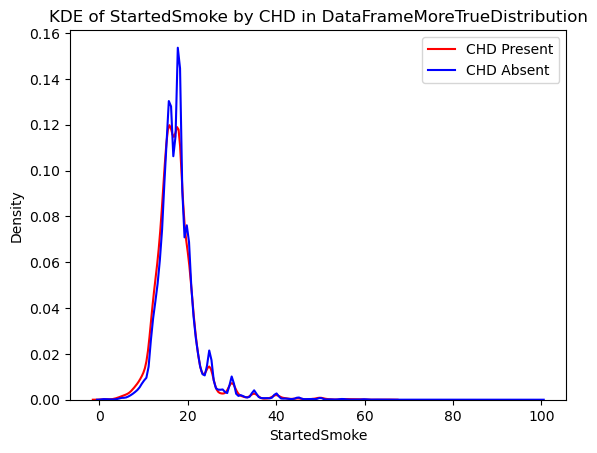

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

df = DataFrameMoreTrueDistribution.copy()
feature = 'StartedSmoke'

# Encode 'CHD' to numeric values
df['CHD_numeric'] = df['CHD'].map({'Yes': 1, 'No': 0})

# Plot KDE for 'SleepTime' against 'CHD'
sns.kdeplot(data=df[df['CHD'] == 'Yes'][feature], label='CHD Present', color='red')
sns.kdeplot(data=df[df['CHD'] == 'No'][feature], label='CHD Absent', color='blue')
plt.xlabel(feature)
plt.ylabel('Density')
plt.title(f'KDE of {feature} by CHD in DataFrameMoreTrueDistribution')
plt.legend()
plt.show()

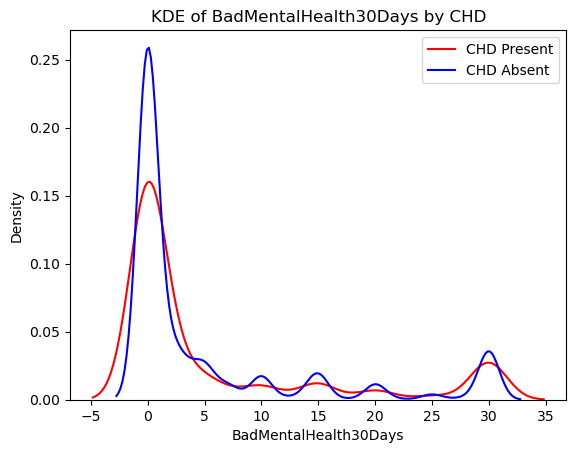

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

df = DataFrameMoreTrueDistribution.copy()
feature = 'BadMentalHealth30Days'

# Encode 'CHD' to numeric values
df['CHD_numeric'] = df['CHD'].map({'Yes': 1, 'No': 0})

# Plot KDE for 'SleepTime' against 'CHD'
sns.kdeplot(data=df[df['CHD'] == 'Yes'][feature], label='CHD Present', color='red')
sns.kdeplot(data=df[df['CHD'] == 'No'][feature], label='CHD Absent', color='blue')
plt.xlabel(feature)
plt.ylabel('Density')
plt.title(f'KDE of {feature} by CHD')
plt.legend()
plt.show()